# Background

The file "rainfall.txt" contains the dataframe of precipitation measurements (rainfall) observed during storms in the state of Illinois in 1960.

# Environment:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from scipy.stats import gamma
from scipy.optimize import minimize

# Question 1

**Load the data from the file 'rainfall.txt'.**

In [2]:
rainfall = pd.read_table('./rainfall.txt', header = None)

**Check the data and show the first ten lines of the data.**

In [3]:
rainfall.head(10)

,0
0,0.020
1,0.001
2,0.001
3,0.120
4,0.080
5,0.420
6,1.720
7,0.050
8,0.010
9,0.010


**Draw an histogram of the data.**

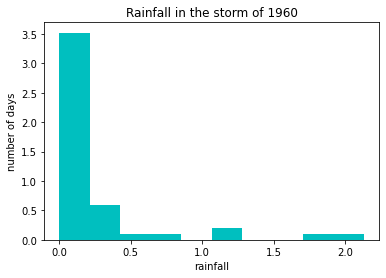

In [4]:
plt.hist(rainfall, density=True, color = 'c')

plt.xlabel('rainfall')
plt.ylabel('number of days')
plt.title("Rainfall in the storm of 1960")

plt.show()

**Comment on the shape of the distribution.**

<font color=blue>
The shape of this distribution is right skewed. 
We can see that fewer data plots are found to the right of the graph and the majority of data lies in the left side.
As the rainfall gets bigger, the number of days gets smaller.

**what is the average rainfall in the storm of 1960? the median rainfall in the storm of 1960? explain why these measures differ.**

In [5]:
rainfall.describe()

,0
count,48.000000
mean,0.220292
std,0.439191
min,0.001000
25%,0.003000
50%,0.045000
75%,0.217500
max,2.130000


<font color=blue>
The average rainfall in the storm of 1960 is 0.220292 while the median rainfall is 0.045.<br>

We get the average by calculating, so it will vary for each data change.
And we get the median by sorting the data, so it is not affected by the largest and smallest extreme values.
    
As the distribution is right skewed and most of our data are in the left of the graph, the median will certainly be a small value. <br>
However, the average will be bigger than the median because there are several data plots in the right side and the average value will be affected by these extreme values.

# Additional Condition

We propose to fit these data with a gamma law parameterized by a shape parameter $a > 0$ (scipy.stats.gamma):
$$PDF(x) = \dfrac{x^{a-1}e^{-x}}{\Gamma(a)}$$

# Question 2

**Find the method of moments estimate $\hat{a}$ of $a$ (explain how you get the formula).**

<font color=blue>
Firstly, we obtain the expectation:
    
Since this is a gamma law whose inverse scale parameter $b$ is $1$, the expectation is as same as the shape parameter $a$.
$$ 
E(X) = \dfrac{a}{b} = \dfrac{a}{1} = a
$$
    
Secondly, we write $a$ as a function of $E(X)$:
$$
a = E(X)
$$
    
Thirdly, we replace $E(X)$ by the sample mean:
$$
\hat{a}_{MM} = \bar{X} = 0.220292
$$


**Plot the estimated density on the same figure as the histogram.**

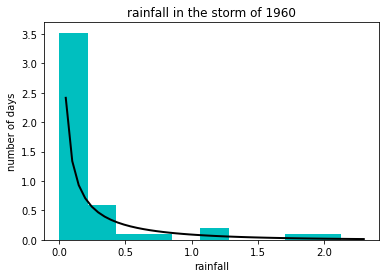

In [6]:
a_MM = np.mean(rainfall) # the method of moments estimate of a
x = np.linspace(gamma.ppf(0.00, a_MM),gamma.ppf(0.99, a_MM), 48) # we have 48 rainfall data
plt.plot(x, gamma.pdf(x, a_MM),'k-', lw=2, label='gamma pdf') # the estimated density

plt.hist(rainfall, density=True, color = 'c') # the histogram

plt.xlabel('rainfall')
plt.ylabel('number of days')
plt.title("rainfall in the storm of 1960")
plt.show()

**Draw a quantile-quantile plot of the sample with the estimated gamma distribution.**

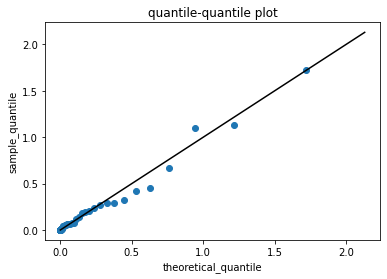

In [7]:
sample_quantile = rainfall.quantile(np.linspace(0,1,48), numeric_only=True) # we have 48 data
theoretical_quantile = gamma.ppf(np.linspace(0,1,48), a_MM) # all the quantiles of the gamma law

plt.plot(np.linspace(0,2.13,100), np.linspace(0,2.13,100), color = 'k') # diagonal: y = x

plt.scatter(theoretical_quantile, sample_quantile) # show all the spots

plt.title('quantile-quantile plot')
plt.xlabel('theoretical_quantile')
plt.ylabel('sample_quantile')
plt.show()

 **What do you think of the resulting fit?**

<font color=blue>
As we can see in the quantile-quantile plot, all the spots of the QQ-plot lie approximately on the diagonal: y = x.
    
That means the distribution of the rainfall sample is similar to the gamma distribution.

# Question 3

**Estimate the sampling distribution and the standard error of $\hat{a}$ by using the bootstrap. Explain (and comment) your code.**

<font color=blue>
    
Firstly we use the bootstrap to get the distribution. 
We do bootstap for 10000 times in total.

In [8]:
bootstrap_sampling_distribution = [] # the list of a_hat_* 

for _ in range(10000): # we do 10000 times bootstraps
    sum = 0
    for _ in range(48): # we draw with replacement 48 times in each bootstrap
        sum += rainfall[0][random.randint(0,47)] # randomly
    bootstrap_sampling_distribution.append(sum/48) # a_hat is always the mean of the samples

<font color=blue>

Secondly we compute the standard error of $\hat{a}$.
By definition of stand error, it's the square root of the variance of $\hat{a}$.

In [9]:
mean = 0.
for i in range(10000):
    mean += bootstrap_sampling_distribution[i]
mean /= 10000

variance = 0.
for i in range(10000):
    variance += (bootstrap_sampling_distribution[i] - mean)**2
variance /= 10000

standard_error = math.sqrt(variance)
print('standard_error: ', standard_error)

standard_error:  0.06306440690640636


**Draw an histogram of the sampling distribution.**

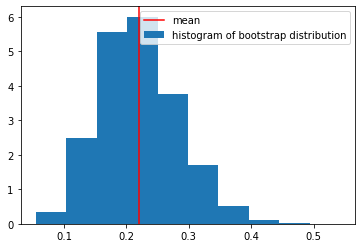

In [10]:
# it's better to visualize the sampling distribution in the form of dataframe
dataframeBootstrap = pd.DataFrame(bootstrap_sampling_distribution)

plt.hist(dataframeBootstrap, density = 'True', label = 'histogram of bootstrap distribution')

plt.axvline(0.220292, 0, 1, c = 'r', label = 'mean') # 0.220292 is the mean

plt.legend()
plt.show()

**Compute a $95\%$ bootstrap confidence interval for $a$.**

In [11]:
# we obtain # the left and right limit of our confidence interval
q1 = np.quantile(dataframeBootstrap - a_MM, 0.975) # 1 - 0.05/2 = 0.975 
q2 = np.quantile(dataframeBootstrap - a_MM, 0.025) # 0.05/2 = 0.025

print("0.95 bootstrap confidence interval: [%.2F,%.2F]" %(a_MM-q1, a_MM-q2))

0.95 bootstrap confidence interval: [0.08,0.33]


# Question 4

**Write a function $logL$ which takes as argument the parameter $a$ and returns the value of
the negative log-likelihood at point $a$.**

<font color=blue>
Let $L$ be the likelihood function $logL$ be the log-likelihood function.<br>
With the formule of likelihood function:
   $L = \prod_{i=1}^{n} pdf(X_{i}) $,
<br>
We can obtain:
   $logL = log(\prod_{i=1}^{n} pdf(X_{i})) = \sum_{i = 1}^{n} logpdf(X_{i})$

In [12]:
def neg_logL(a):
    """
    param: the parameter a
    return: the value of the negative log-likelihood at point a
    """
    return -(np.sum(gamma.logpdf(rainfall, a))) # we use sum here beacuse we used gamma.logpdf but not gamma.pdf

**Draw the graph of the negative log-likeliood.**

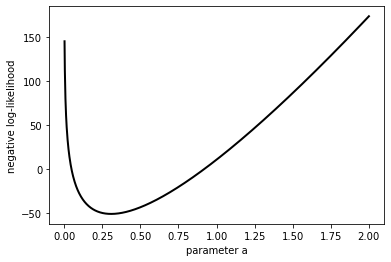

In [13]:
x = np.linspace(0.0, 2.0, 1000) # we divide [0, 2] to 1000 points
y = []
for i in range(1000):
    y.append(neg_logL(x[i])) # and we obtain the function values 

plt.plot(x, y, 'k-', lw=2) 

plt.xlabel('parameter a')
plt.ylabel('negative log-likelihood')
plt.show()

# Question 5

**Find the maximum likelihood estimate (MLE) of $a$ (use an optimization algorithm such as minimize).**

<font color=blue>
By definition, the maximum likelihood estimate(MLE) of $a$ is the value of $a$ that maximizes
of the likelihood $L_{X_1,...,X_n}(a)$.<br>
In other words, MLE(a) is the value of $a$ that maximizes the log-likelihood $logL$.<br>
So in order to get MLE, we just need to find $argmin(neg\_logL)$

In [14]:
MLE_a = minimize(neg_logL, x0 = 0.2, method =  'SLSQP') # method : Sequential Least Squares Programming 

print('the maximum likelihood estimate of a: ', MLE_a.x[0])

the maximum likelihood estimate of a:  0.308013222081308


# Question 6(bonus)

**Find an approximate value of the standard error of the MLE of $a$.**

<font color=blue>
Firstly we need to rewrite the negaive log-likelihood function.<br>
This is because during the bootstrap we use the resampled rainfall data.

In [15]:
def neg_logL_bootstrap(a):
    """
    param: the parameter a
    return: the value of the negative log-likelihood at point a
    """
    return -(np.sum(gamma.logpdf(bootstrap_rainfall, a))) 

<font color=blue>
To get the approximate standard error of the MLE of $a$, we use the bootstrap on the MLE of $a$ again to obtain the sampling distribution of MLE.

In [16]:
bootstrap_sampling_distribution_MLE = [] # the list of MLE_* 

for _ in range(10000): # we still do 10000 times bootstraps
    bootstrap_rainfall = []
    for _ in range(48): # we draw with replacement 48 times in each bootstrap
        bootstrap_rainfall.append(rainfall[0][random.randint(0,47)] )# randomly
    
    MLE_a_bootstrap = minimize(neg_logL_bootstrap, x0 = 0.2, method =  'SLSQP') # same as before
    bootstrap_sampling_distribution_MLE.append(MLE_a_bootstrap.x[0])

<font color=blue>
The rest part is just as same as before:<br>
We calculate the mean, variance, SE.

In [17]:
mean_MLE = 0.
for i in range(10000):
    mean_MLE += bootstrap_sampling_distribution_MLE[i]
mean_MLE /= 10000

variance_MLE = 0.
for i in range(10000):
    variance_MLE += (bootstrap_sampling_distribution_MLE[i] - mean)**2
variance_MLE /= 10000

standard_error_MLE = math.sqrt(variance_MLE)
print('standard_error of MLE: ', standard_error_MLE)

standard_error of MLE:  0.09488067914419164


**Compute a 95% confidence interval for $a$ based on the MLE.**

<font color=blue>
We use the same method as Question3.<br>
The only difference is that we change the bootstrap quantiles. 

In [18]:
dataframeBootstrap_MLE = pd.DataFrame(bootstrap_sampling_distribution_MLE)

# we obtain # the left and right limit of our confidence interval
ql = np.quantile(dataframeBootstrap_MLE - MLE_a.x[0], 0.975) # 1 - 0.05/2 = 0.975 
qr = np.quantile(dataframeBootstrap_MLE - MLE_a.x[0], 0.025) # 0.05/2 = 0.025

print("0.95 bootstrap confidence interval: [%.2F,%.2F]" %(MLE_a.x[0]-ql, MLE_a.x[0]-qr))

0.95 bootstrap confidence interval: [0.24,0.36]
